In [1]:
import os
os.chdir('K:/ecole/github/televerser/wisdom of crowds')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### ETL

In [2]:
#read data
y0matrix2019=pd.read_csv('y0matrix2019.csv')

y1matrix2020=pd.read_csv('y1matrix2020.csv')

monthly=pd.read_csv('monthly.csv')

annual=pd.read_csv('annual.csv')

In [3]:
#set index
y0matrix2019.set_index('Source Name',inplace=True)

y1matrix2020.set_index('Source Name',inplace=True)

monthly.set_index('Date',inplace=True)
monthly.index=pd.to_datetime(monthly.index)
monthly.columns=y0matrix2019.columns

annual=annual.pivot(index='Date',columns='Name',values='Value')
annual.index=pd.to_datetime(annual.index)

In [4]:
#compute forecast error
y0matrix2019_error=np.subtract(y0matrix2019,annual['2019':'2019'])

y1matrix2020_error=np.subtract(y1matrix2020,annual['2020':'2020'])

In [5]:
#aggregate y+0 forecast and y+1 forecast
erreur=(abs(np.divide(y0matrix2019_error,annual['2019':'2019']))+abs(np.divide(y1matrix2020_error,annual['2020':'2020'])))/2

In [6]:
#compute forecast error by banks and sort
erreur_by_banks=dict(zip(erreur.index,erreur.mean(axis=1)))
erreur_by_banks=dict(sorted(erreur_by_banks.items(),key=lambda X:X[1]))

In [7]:
#compute forecast error by commodities and sort
erreur_by_commodities=dict(zip(erreur.columns,erreur.mean(axis=0)))
erreur_by_commodities=dict(sorted(erreur_by_commodities.items(),key=lambda X:X[1]))

In [8]:
#compute forecast error by using spot price
y0spot2019_error=np.divide(monthly['2019-08':'2019-08'],annual['2019':'2019'])-1
y1spot2020_error=np.divide(monthly['2019-08':'2019-08'],annual['2020':'2020'])-1

#aggregate y+0 forecast and y+1 forecast
erreur_by_spot=list(((abs(y0spot2019_error)+abs(y1spot2020_error))/2).to_dict(orient='index').values())[0]

In [9]:
#compute unit volatility
unit_volatility=monthly.std()/monthly.mean()
unit_volatility=unit_volatility.reindex(erreur_by_commodities.keys())

### Viz

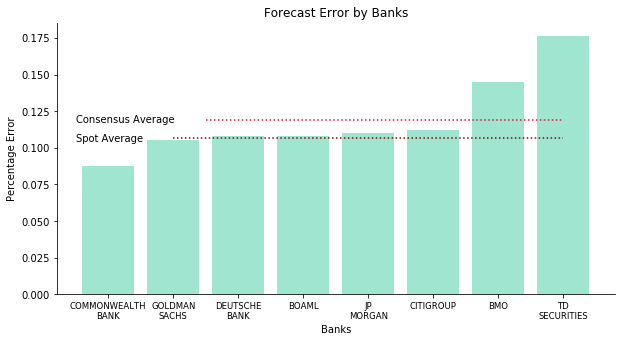

In [10]:
#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(range(len(erreur_by_banks)),
        erreur_by_banks.values(),
        color='#a0e5d0')
plt.text(-0.5,erreur.mean().mean(),
         'Consensus Average',va='center')
plt.hlines(erreur.mean().mean(),
           xmin=1.5,xmax=len(erreur_by_banks)-1,
           linestyle=':',color='crimson')
plt.text(-0.5,np.mean(list(erreur_by_spot.values())),
         'Spot Average',va='center')
plt.hlines(np.mean(list(erreur_by_spot.values())),
           xmin=1,xmax=len(erreur_by_banks)-1,
           linestyle=':',color='maroon')
plt.xticks(range(len(erreur_by_banks)),
           [i.replace(' ','\n') for i in erreur_by_banks.keys()],
           fontsize=8.5)
plt.xlabel('Banks')
plt.ylabel('Percentage Error')
plt.title('Forecast Error by Banks')
plt.show()

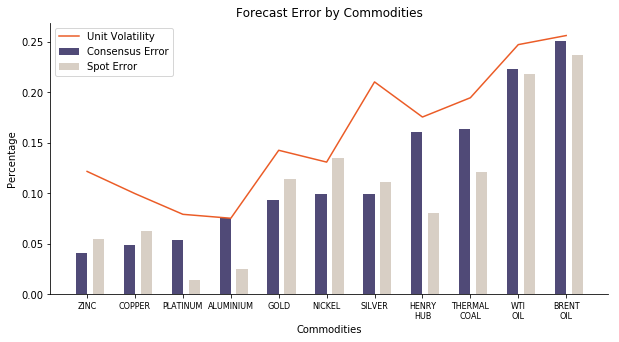

In [11]:
#viz
section_width=7
bar_width=4
intra_width=2
ticks=[]

ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for ind,val in enumerate(erreur_by_commodities):
    x1=(ind+1)*section_width+(2*ind)*bar_width+ind*intra_width
    tick=x1+bar_width/2
    x2=x1+bar_width+intra_width
    bar1=plt.bar(x1,erreur_by_commodities[val],
            color='#504a77',width=bar_width)
    bar2=plt.bar(x2,erreur_by_spot[val],
            color='#d8cfc5',width=bar_width)
    ticks.append(tick)
line,=plt.plot(ticks,unit_volatility,
         label='Volatility',c='#eb5c27')
plt.xticks(ticks,
           [i.replace(' ','\n') for i in erreur_by_commodities.keys()],
           fontsize=8)
plt.legend((line,bar1,bar2),
           ('Unit Volatility','Consensus Error','Spot Error'),loc=0)
plt.xlabel('Commodities')
plt.ylabel('Percentage')
plt.title('Forecast Error by Commodities')
plt.show()